In [8]:
from ecell4 import *
import numpy as np
%matplotlib inline
import math
import sys
import matplotlib.pyplot as plt
from ecell4.extra import ensemble

def run(run,rv,Dc,Dt,L,phi,phit,duration):
    rng = core.GSLRandomNumberGenerator(run)
    dt = (2*rv)**2 / (6*Dt)
    tt = np.logspace(math.log10(dt),math.log10(duration),100)
    tt = np.insert(tt,0,[0,dt])
    with species_attributes():
        C | {'D':str(Dc),'radius':str(rv)}
        T | {'D':str(Dt),'radius':str(rv)}
    m=get_model()

    msd = np.zeros(len(tt),float)
    w = spatiocyte.SpatiocyteWorld(Real3(L,L,L),rv,rng)
    size=tuple(w.calculate_shape(Real3(L,L,L),rv))    
    Nev = size[0]*size[1]*size[2]
    Nt=int(Nev*phit)
    Nc=int(Nev*phi)
    if run==1:
        print('run{},rv{},Dc{},Dt{},L{},\n total empty voxels{},Nt{},Nc{},phi{},phit{:.2},dt{:.3},duration{}'.format(
            run,rv,Dc,Dt,L,Nev,Nt,Nc,phi,Nt/Nev,dt,tt[-1]))
    w.bind_to(m)
    w.add_molecules(Species('C'),Nc)
    w.add_molecules(Species('T'),Nt)
    sim = spatiocyte.SpatiocyteSimulator(w)
    pids = [pid for pid, p in w.list_particles(Species("T"))] #particle IDs
    obs = TimingTrajectoryObserver(tt,pids,True,dt)
    sim.run(tt[-1],obs)
    data=obs.data()
    for i in range(Nt):
        msd += np.array(
            [np.linalg.norm(np.array(tuple(pos)) - np.array(tuple(data[i][0]))) ** 2
                 for pos in data[i]])  
    return msd,tt

def singlerun(job,job_id,task_id):
    job.update({'run':task_id})
    out=run(**job)
    return out

In [49]:
simrun=50
nproc=65
L=0.5
rv=0.005
Dc=0
Dt=1.
phit=0.01
duration=1
#for phi in [0.0,0.1,0.3,0.5,0.7,0.8,0.85]:    
phi=0.9
w = spatiocyte.SpatiocyteWorld(Real3(L,L,L),rv)
#(c,r,l)=w.shape()
#Nev=(c - 2) * (r - 2) * (l - 2)
size=tuple(w.calculate_shape(Real3(L,L,L),rv))    
Nev = size[0]*size[1]*size[2]   
Nt=int(Nev*phit)
jobs=[{'rv':rv,'Dc':Dc,'Dt':Dt,'L':L,'phi':phi,'phit':phit,'duration':duration}]
output=ensemble.run_multiprocessing(singlerun,jobs,n=simrun,nproc=nproc)
output=np.array(output)
tt=output[0][1][1]
msd=np.mean(output[0][:,0],axis=0)/Nt
name='/home/chew/outputdata/LS3Dcrowd_Dt{}Dc{}phi{:.3}phit{:.3}Nt{}rm{:.3}L{}'.format(Dt,Dc,phi,phit,Nt,rv,L)
f=open(name,'w')
np.savetxt(name,np.column_stack([tt,msd]),delimiter=',')
f.close()    
print('save in ',name)

run1,rv0.005,Dc0,Dt1.0,L0.5,
 total empty voxels193440,Nt1934,Nc174096,phi0.9,phit0.01,dt1.67e-05,duration1.0
save in  /home/chew/outputdata/LS3Dcrowd_Dt1.0Dc0phi0.9phit0.01Nt1934rm0.005L0.5


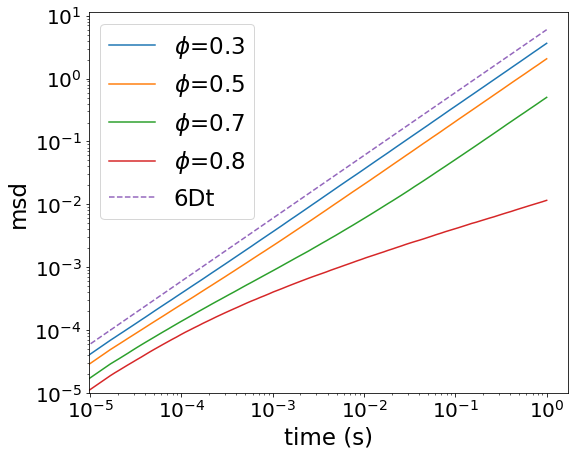

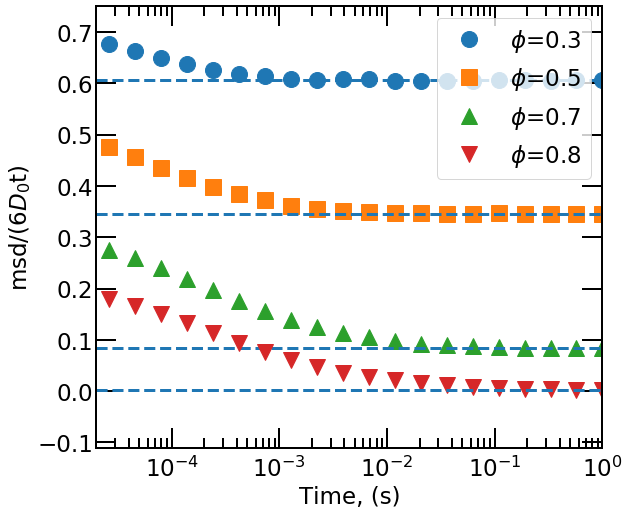

In [7]:
from ecell4 import *
import numpy as np
%matplotlib inline
import math
import sys
import matplotlib.pyplot as plt
from ecell4.extra import ensemble
L=0.5
rv=0.005
Dc=0
Dt=1.
phit=0.01
duration=1.
Nt=1934
s=20
Deffs=[]
phis = [0.3,0.5,0.7,0.8]#,0.9]
fig1,ax1=plt.subplots(1,1,figsize=(8.6,7))
fig2,ax2=plt.subplots(1,1,figsize=(8.6,7))
fs=23
ms=16
lw=3
i=0
DS=5
mk=['o','s','^','v']
for phi in phis:
    name='/home/chew/wrk/ecellwork/MLM/data/LS3Dcrowd_Dt{}Dc{}phi{:.3}phit{:.3}Nt{}rm{:.3}L{}'.format(Dt,Dc,phi,phit,Nt,rv,L)
    dat=np.genfromtxt(name,delimiter=',')
    t=dat.T[0]
    msd=dat.T[1]
    Deff =msd[1:]/t[1:]/6/Dt
    ax1.loglog(t,msd,'-',label='$\phi$='+str(phi))   
    #plt.savefig('/home/chew/ecellwork/figure/3Dcrowding_Spa_msd_t.png')
    ax2.tick_params(labelsize=s)
    ax2.semilogx(t[1:][::DS],Deff[::DS],marker=mk[i],label='$\phi$='+str(phi),markersize=ms,linestyle=' ')
    i+=1
    #plt.savefig('/home/chew/ecellwork/figure/3Dcrowding_Spa_Deff_t.png')
    idx=t[1:]>0.2
    Deffs.append(np.mean(Deff[idx]))
    ax2.axhline(np.mean(Deff[idx]),linestyle='--',linewidth=lw)
ax1.loglog(t,6*Dt*t,'--',label='6Dt')
ax1.set_xlabel('time (s)',fontsize=fs)
ax1.set_ylabel('msd',fontsize=fs)
ax1.tick_params(labelsize=s)
ax1.legend(loc='best',fontsize=fs)
ax2.legend(loc='best',fontsize=fs)
ax2.set_xlabel('Time, (s)',fontsize=fs)
ax2.set_xlim(2e-5,1)
ax2.set_ylabel('msd/(6$D_0$t)',fontsize=fs)
ax2.tick_params(labelsize=fs)      
fig2.tight_layout(pad=0)
ax2.yaxis.set_ticks_position('both')
ax2.xaxis.set_ticks_position('both')
ax2.tick_params(axis='both',which='both',direction='in',length=10,width=2)
ax2.tick_params(axis='both',which='major',length=20,width=2)
ax2.set_ylim(-0.11,0.75)
plt.gcf().subplots_adjust(left=0.15)
ax2.tick_params(axis='x',which='major',pad=8)
#fig2.set_size_inches(8.6,7)
for axis in ['top','bottom','left','right']:
      ax2.spines[axis].set_linewidth(2)